# Installation

In [1]:
from __future__ import absolute_import, division, print_function

import base64
import imageio
import IPython
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
#import pyvirtualdisplay

import tensorflow as tf

from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.networks import q_network
from tf_agents.policies import random_tf_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

In [8]:
tf.compat.v1.enable_v2_behavior()

# Set up a virtual display for rendering OpenAI gym environments.
#display = pyvirtualdisplay.Display(visible=0, size=(1400, 900)).start()

In [6]:
tf.version.VERSION

'2.6.0'

# Hyper Parameters

In [2]:
num_iterations = 20000 # @param {type:"integer"}

initial_collect_steps = 1000  # @param {type:"integer"} 
collect_steps_per_iteration = 1  # @param {type:"integer"}
replay_buffer_max_length = 100000  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 200  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 1000  # @param {type:"integer"}

## Environment

In [3]:
env_name = 'CartPole-v0'
env = suite_gym.load(env_name)

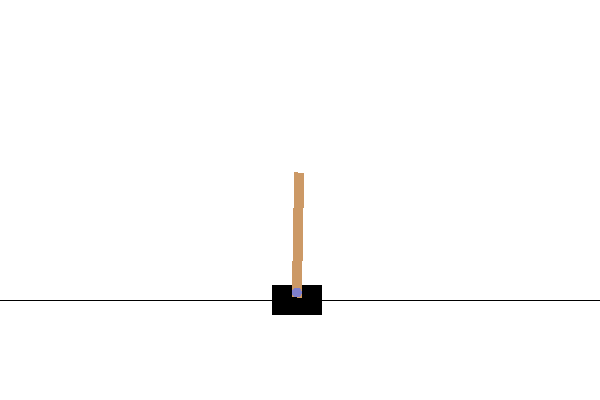

In [4]:
env.reset()
PIL.Image.fromarray(env.render())

In [5]:
print('Observation Spec:')
print(env.time_step_spec().observation)

Observation Spec:
BoundedArraySpec(shape=(4,), dtype=dtype('float32'), name='observation', minimum=[-4.8000002e+00 -3.4028235e+38 -4.1887903e-01 -3.4028235e+38], maximum=[4.8000002e+00 3.4028235e+38 4.1887903e-01 3.4028235e+38])


In [6]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [7]:
print('Reward Spec:')
print(env.time_step_spec().reward)

Reward Spec:
ArraySpec(shape=(), dtype=dtype('float32'), name='reward')


In [8]:
time_step = env.reset()
print('Time step:')
print(time_step)

action = np.array(1, dtype=np.int32)

next_time_step = env.step(action)
print('Next time step:')
print(next_time_step)

Time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.02393607, -0.0032783 ,  0.03562655, -0.0472406 ], dtype=float32),
 'reward': array(0., dtype=float32),
 'step_type': array(0)})
Next time step:
TimeStep(
{'discount': array(1., dtype=float32),
 'observation': array([ 0.0238705 ,  0.19131516,  0.03468174, -0.32847357], dtype=float32),
 'reward': array(1., dtype=float32),
 'step_type': array(1)})


In [9]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

In [11]:
train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

## Agents

In [12]:
fc_layer_params = (100,)

q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

In [14]:
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter)

agent.initialize()

## Policy

In [15]:
eval_policy = agent.policy
collect_policy = agent.collect_policy